# **M1. ACTIVIDAD**
Yuna Chung A01709043

## **Propósito**
Conocer y aplicar una herramienta para la implementación de sistemas multiagentes.

# **Instrucciones**
Para este problema, debereás entregar, **de manera individual**, un informe en PDF que estudie las estadísticas de un robot de limpieza reactivo, así como el enlace al repositorio en Github del código desarrollado para esta actividad. El código debe ajustarse al estilo soclicita en el siguiente documento.

**Dado:**
- Habitación de MxN espacios
- Número de agentes
- Porcentaje de celdas inicialmente sucias
- Tiempo máximo de ejecución

**Realiza la siguiente simulación:**
- Inicializa las celdas sucias (ubicaciones aleatorias)
- Todos los agentes empiezan en la celda [1,1]
- En cada paso de tiempo:
    - Si la celda está sucia, entonces aspira
    - Si la celda está limpia, el agente elije una dirección aleatoria para moverse (unas de las 8 celdas vecinas) y elije la acción de movimiento (si no puede moverse allí, permanecerá en la misma celda)
- Se ejecuta el tiempo máximo establecido

**Deberás recopilar la siguiente información durante la ejecución:**
- Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo)
- Porcentaje de celdas limpias después del termino de la simulación
Número de movimientos realizados por todos los agentes.

Analiza cómo la cantidad de agentes impacta el tiempo dedicado, así como la cantidad de movimientos realizados. Desarrollar un informe con lo observado.

In [7]:
from mesa import Agent, Model

from mesa.space import MultiGrid

from mesa.time import RandomActivation

from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time as tm

In [8]:
class CleaningRobot(Agent):
    def __init__(self, id, model):
        super().__init__(id, model)

    def step(self):
        if (self.model.floor[self.pos[0]][self.pos[1]] == 1):
            self.clean()
        self.move()

    def clean(self):
        self.model.floor[self.pos[0]][self.pos[1]] = 0

    def move(self):
        close_cells = self.model.grid.get_neighborhood(self.pos, 
                                                       moore=True, 
                                                       include_center=False)
        is_possible = [step for step in close_cells if self.model.grid.is_cell_empty(step)]

        if is_possible:
            self.model.grid.move_agent(self, self.random.choice(is_possible))

In [9]:
class CleaningModel(Model):
    def __init__(self, width, height, dirty_probability, num_agents):
        self.num_agents = num_agents
        self.initial_time = None
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.floor = np.zeros((width, height))
        self.datacollector = DataCollector(
            model_reporters = {"Clean": self.count_clean,
                               "Position": self.find_position},
        )

        for i in range(self.num_agents):
            agent = CleaningRobot(i, self)
            self.grid.place_agent(agent, (1,1))
            self.schedule.add(agent)

        for x in range(self.grid.width):
            for y in range(self.grid.height):
                if self.random.random() < dirty_probability:
                    self.floor[x][y] = 1

    def count_clean(self):
        return self.floor.copy()
    
    def find_position(self):
        agent_position = np.zeros((self.width, self.height))
        for agent in self.schedule.agents:
            agent_position[agent.pos[0]][agent.pos[1]] = 1
        return agent_position

    def step(self):
        if self.initial_time is None:
            self.initial_time = tm.time()

        self.datacollector.collect(self)
        self.schedule.step()


In [10]:
WIDTH = 10
HEIGHT = 10
MAX_STEPS = 100
DIRTY_PROBABILITY = 0.9
NUM_AGENTS = 2

model = CleaningModel(WIDTH, HEIGHT, DIRTY_PROBABILITY, NUM_AGENTS)
for i in range(MAX_STEPS):
    model.step()

In [11]:
all_grids = model.datacollector.get_model_vars_dataframe()

Time to clean:  0.01981  seconds
Dirty cells:  32.0
Dirty cells percentage:  32.0


C:\Users\jn792\AppData\Local\Temp\ipykernel_30412\1926625595.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dirty_cells = all_grids.iloc[MAX_STEPS - 1][0].sum()


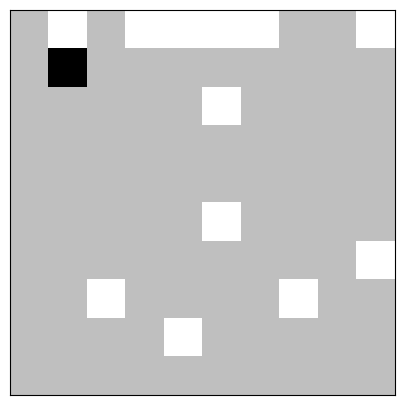

In [12]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])

data = all_grids.get("Clean") + 3 * all_grids.get("Position")
patch = plt.imshow(data[0], cmap=plt.cm.binary)

def animate(frame):
    patch.set_data(data[frame])

anim = animation.FuncAnimation(fig, animate, frames=MAX_STEPS)

end_time = tm.time()
cleaning_time = float("{:.5f}".format(end_time - model.initial_time))
print("Time to clean: ",cleaning_time, " seconds")

dirty_cells = all_grids.iloc[MAX_STEPS - 1][0].sum()
print("Dirty cells: ", dirty_cells)
print("Dirty cells percentage: ", dirty_cells / (WIDTH * HEIGHT) * 100)

In [13]:
anim

## **Escenario 1**

- 1 agente
- 90% de celdas sucias

## **Escenario 2**

- 2 agentes
- 90% de celdas sucias

## **PREGUNTAS**

**¿Cuántos pasos de simulación toma limpiar todo el espacio?**

**¿Qué porcentaje de celdas sucias queda con los siguientes pasos de simulación: 100, 1000, 10000?**